In [1]:
import time, enum, math
import numpy as np 
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation 
from mesa.space import MultiGrid # To make grid
from mesa.datacollection import DataCollector # Traking the agent 

In [2]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    VACCINATED = 1
    INFECTED_S = 2
    INFECTED_V = 3
    RECOVERED_S = 4
    RECOVERED_V = 5

In [4]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, SV,unique_id, model):
        super().__init__(unique_id, model)
        self.SV = SV
        if self.SV == "S":
            self.state = State.SUSCEPTIBLE
        else:
            self.state = State.VACCINATED 
#         self.infection_time = 0
    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    
    
    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED_S: 
            recovery_rate_Is = self.model.gamma
            
            recovered = np.random.choice([0,1], p=[recovery_rate_Is,1-recovery_rate_Is])
            if recovered == 0:
                self.state = State.RECOVERED_S

                
        if self.state == State.INFECTED_V: 
            recovery_rate_Iv = self.model.gamma * self.model.delta
            
            recovered = np.random.choice([0,1], p=[recovery_rate_Iv,1-recovery_rate_Iv])
            if recovered == 0:
                self.state = State.RECOVERED_V

            

    def contact(self):
        """Find close contacts and infect"""
        
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:

            for other in cellmates:
                
                    #If randomly not conntected with other agent
                if self.random.random() > self.model.beta:
                    continue
                    
                    #If Contatct Wtih Other agent
                if self.state is State.INFECTED_S and other.state is State.SUSCEPTIBLE:
                    rate = self.model.beta
                    decision = np.random.choice([0,1], p=[rate,1-rate])
                    
                    if decision == 0:
                        other.state = State.INFECTED_S
   
                        
                if self.state is State.INFECTED_S and other.state is State.VACCINATED:   
                    rate = self.model.beta * (1-self.model.eta)*self.model.effectiveness
                    decision = np.random.choice([0,1], p=[rate,1-rate])
                    
                    if decision == 0:
                        other.state = State.INFECTED_V

    
                if self.state is State.INFECTED_V and other.state is State.SUSCEPTIBLE:
                    rate = self.model.beta
                    decision = np.random.choice([0,1], p=[rate,1-rate])
                    
                    if decision == 0:
                        other.state = State.INFECTED_S

                    
                if self.state is State.INFECTED_S and other.state is State.VACCINATED:
                    rate = self.model.beta * (1-self.model.eta)*self.model.effectiveness
                    decision = np.random.choice([0,1], p=[rate,1-rate])
                    
                    if decision == 0:
                        other.state = State.INFECTED_V
                    
    def step(self):
        self.status()
        self.move()
        self.contact()


In [5]:
class SIRVModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10,num_vaccination = 5,width=10, height=10,
                beta = 0.833,gamma = 1/3, delta = 3,eta = 0.3, effectiveness = 0.5):
        
        self.num_agents = N
        self.num_vaccination = num_vaccination
        
        
        #parameters
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.eta = eta
        self.effectiveness = effectiveness
        

        
        
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)



        self.running = True
        self.dead_agents = []
        
        # Agent Creation 
        for i in range(self.num_agents):
            if i < self.num_vaccination:
                a = MyAgent("V",i, self)
            else:
                a = MyAgent("S", i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            

            # If want to make some agent initially infected but here we take initially 
            if a.state == State.VACCINATED:
                infected = np.random.choice([0,1], p=[0.01,0.99])
                
                if infected == 0:
                    a.state = State.INFECTED_V

                
            elif a.state == State.SUSCEPTIBLE:
                infected = np.random.choice([0,1], p=[0.03,0.97])
                if infected == 0:
                    a.state = State.INFECTED_S

                
        # Collecting States of agent
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini}, 
            agent_reporters={"State": "state"})
            
        
 
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Vaccinated','Infected_S','Infected_V','Recovered_S', 'Recovered_V']
    X.columns = labels[:len(X.columns)]
    return X

In [7]:
population=30000
steps = 60
st=time.time()
model = SIRVModel(N=population, num_vaccination=population*0.5,width= 110,height=110)
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))
get_column_data(model).to_csv("Data.csv")

23.107040643692017
      Susceptible  Vaccinated  Infected_S  Infected_V  Recovered_S  \
Step                                                                 
0           14564       14868         436         132            0   
1           14239       14687         547          99          214   
2           13891       14481         646         106          463   
3           13509       14223         762         123          729   
4           13169       13957         802         123         1029   
5           12836       13725         804         103         1360   
6           12493       13505         838         123         1669   
7           12153       13240         872         139         1975   
8           11804       13006         899         125         2297   
9           11531       12779         802         117         2667   
10          11273       12558         727         118         3000   
11          11038       12389         697         102         3265   
1

,Susceptible,Vaccinated,Infected,Recoverd
Step,,,,
0,14564,15000,568,0
1,14239,14786,646,428
2,13891,14587,752,876
3,13509,14346,885,1383
4,13169,14080,925,1949


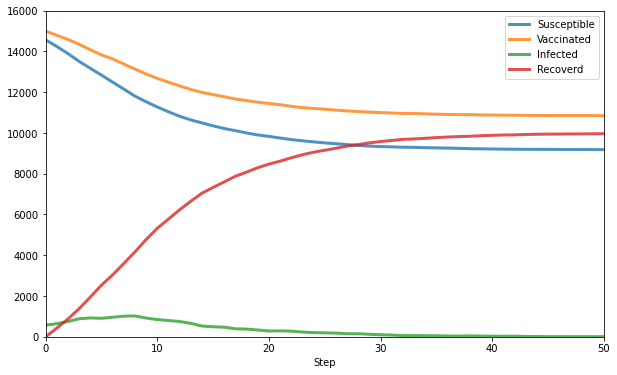

In [8]:
def prep(model):
    X = get_column_data(model)
    X["Vaccinated"] = X["Vaccinated"] + X["Infected_V"] 
    X["Infected"] = X['Infected_S'] + X['Infected_V']
    X["Recoverd"] = X["Recovered_S"] + X["Recovered_V"]
    X.drop(columns=['Infected_S','Infected_V','Recovered_V','Recovered_S'], axis=1,inplace=True)
    X.to_csv("MergeColumn.csv")
    return X

X = prep(model)
f,ax= plt.subplots(1,1,figsize=(10,6))
X.plot(ax=ax,lw=3,alpha=0.8,xlim=[0,50],ylim=[0,16000])
plt.plot()
plt.savefig('SIRV.jpg',dpi=500)
X.head()

# Interactive Plot

In [9]:
def grid_values(model):
    """Get grid states"""
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        agents, x, y = cell
        c=None
        for a in agents:
            c = a.state
        if c == State.INFECTED_S or c == State.INFECTED_V:
            c = 2
        if c == State.RECOVERED_S or c== State.RECOVERED_V:
            c = 3
        agent_counts[x,y] = c
    df=pd.DataFrame(agent_counts)  
    return df

st=time.time()
x=grid_values(model)
print (time.time()-st)
x.to_csv("Grid_Value.csv")

0.02657008171081543


In [10]:
def plot_cells_bokeh(model):
    """Plot model grid values as a grid"""
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=grid_values(model)
    df = pd.DataFrame(df.stack(), columns=['value']).reset_index()    
    columns = ['value']
    x = [(i, "@%s" %i) for i in columns]    
    hover = HoverTool(
        tooltips=x, point_policy='follow_mouse')
    colors = Category10[4]
    mapper = LinearColorMapper(palette=colors, low=df.value.min(), high=df.value.max())
    p = figure(plot_width=500,plot_height=500, tools=[hover], x_range=(-1,w), y_range=(-1,w))
    p.rect(x="level_0", y="level_1", width=1, height=1,
       source=df,
       fill_color={'field':'value', 'transform': mapper},
       line_color='black')
    p.background_fill_color = "black"
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

p=plot_cells_bokeh(model)
pn.pane.Bokeh(p)

Bokeh(Figure)

In [11]:
!pip install selenium


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:

from bokeh.io import export_png


In [17]:

def plot_states_bokeh(model,title=''):
    """Plot cases per country"""
    X = prep(model)
    X = X.reset_index()
    source = ColumnDataSource(X)
    i=0
    colors = Category10[4]
    items=[]
    p = figure(plot_width=60,plot_height=40,tools=[],title=title,x_range=(0,60))        
    for c in X.columns[1:]:
        line = Line(x='Step',y=c,line_width=3,line_color=colors[i],line_alpha=.8,name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c,[glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='bottom_right',   
                items=items))
    p.background_fill_color = "#e1e1ea"
    p.background_fill_alpha = 0.5
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'

    return p

p = plot_states_bokeh(model)
#pn.pane.Bokeh(p)

In [18]:
plot_pane = pn.pane.Bokeh()
grid_pane = pn.pane.Bokeh()
pn.Row(plot_pane,grid_pane,sizing_mode='stretch_width')

Row(sizing_mode='stretch_width')
    [0] Bokeh(None)
    [1] Bokeh(None)

In [19]:
population=30000
steps = 60
st=time.time()
model = SIRVModel(N=population, num_vaccination=population*0.5,width= 110,height=110, beta = 0.85)
model.step()
for i in range(steps):
    model.step()    
    p1=plot_states_bokeh(model,title='step=%s' %i)
    plot_pane.object = p1
    p2=plot_cells_bokeh(model)
    grid_pane.object = p2
    time.sleep(0.0001)
print (time.time()-st)

92.82668948173523


# HeatMaps